In [29]:
%reset -f
import csv
import copy
import json
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from disaggregator import data, config, spatial, plot
from shapely.geometry import Point, MultiPolygon, Polygon

In [61]:
nuts = data.database_shapes()
nuts = nuts.drop(columns = ["gen", "fl_km2"])

centroids = nuts.centroid

x_coord = centroids.x
y_coord = centroids.y

preReg = []
with open("data_in/regional/t_nuts3_lk.csv", 'r') as f:
    dataCSV = csv.DictReader(f)
    for row in dataCSV:
        preReg.append(row)

regions = {}
for r in preReg:
    regions[str(r["id_ags"])] = r["natcode_nuts3"]

In [31]:
with open("project_data/in/heat_demand.json", 'r', encoding = "utf-8") as file:
    heating_demand = json.load(file)

# Heating structure (or energy carriers): 9: Hard coal; 10: brown coal; 11: Natrual gas; 34: Heating oil; 
# 35: Biomass (solid); 68: Ambient heating; 69: Solar heat; 71: District heating; 72: electrical energy;
# 218: Biomass (excluding wood, biogas)

energy_carriers = {"9" : "Hard coal", "10" : "Brown coal", "11" : "Natural gas", "34" : "Heating oil",
                   "35" : "Biomass (solid)", "68" : "Ambient heating", "69" : "Solar heat", "71" : "District heating",
                   "72" : "Electrical energy", "218" : "Biomass"}

energy_need = {}

for h in heating_demand:
    region = regions[str(h["id_region"])]
    if (region in energy_need):
        energy_need[region][energy_carriers[str(h["internal_id"][0])]] = h["value"]
    else:
        energy_need[region] = {}
        for key in energy_carriers.keys():
            energy_need[region][energy_carriers[key]] = 0
        energy_need[region][energy_carriers[str(h["internal_id"][0])]] = h["value"]

# Correct for DE915 and DE919 -> DE91C
energy_need["DE91C"] = {}
for key in energy_carriers.keys():
    energy_need["DE91C"][energy_carriers[key]] = energy_need["DE915"][energy_carriers[key]] + energy_need["DE919"][energy_carriers[key]]

del energy_need["DE915"]
del energy_need["DE919"]

In [32]:
nuts["x"] = x_coord
nuts["y"] = y_coord

cols = [[] for _ in range(len(energy_carriers.items()))]

for r in energy_need.items():
    for i, e in enumerate(energy_carriers.items()):
        cols[i].append( r[1][e[1]] )

for i, e in enumerate(energy_carriers.items()):
    nuts[e[1]] = copy.deepcopy(cols[i])

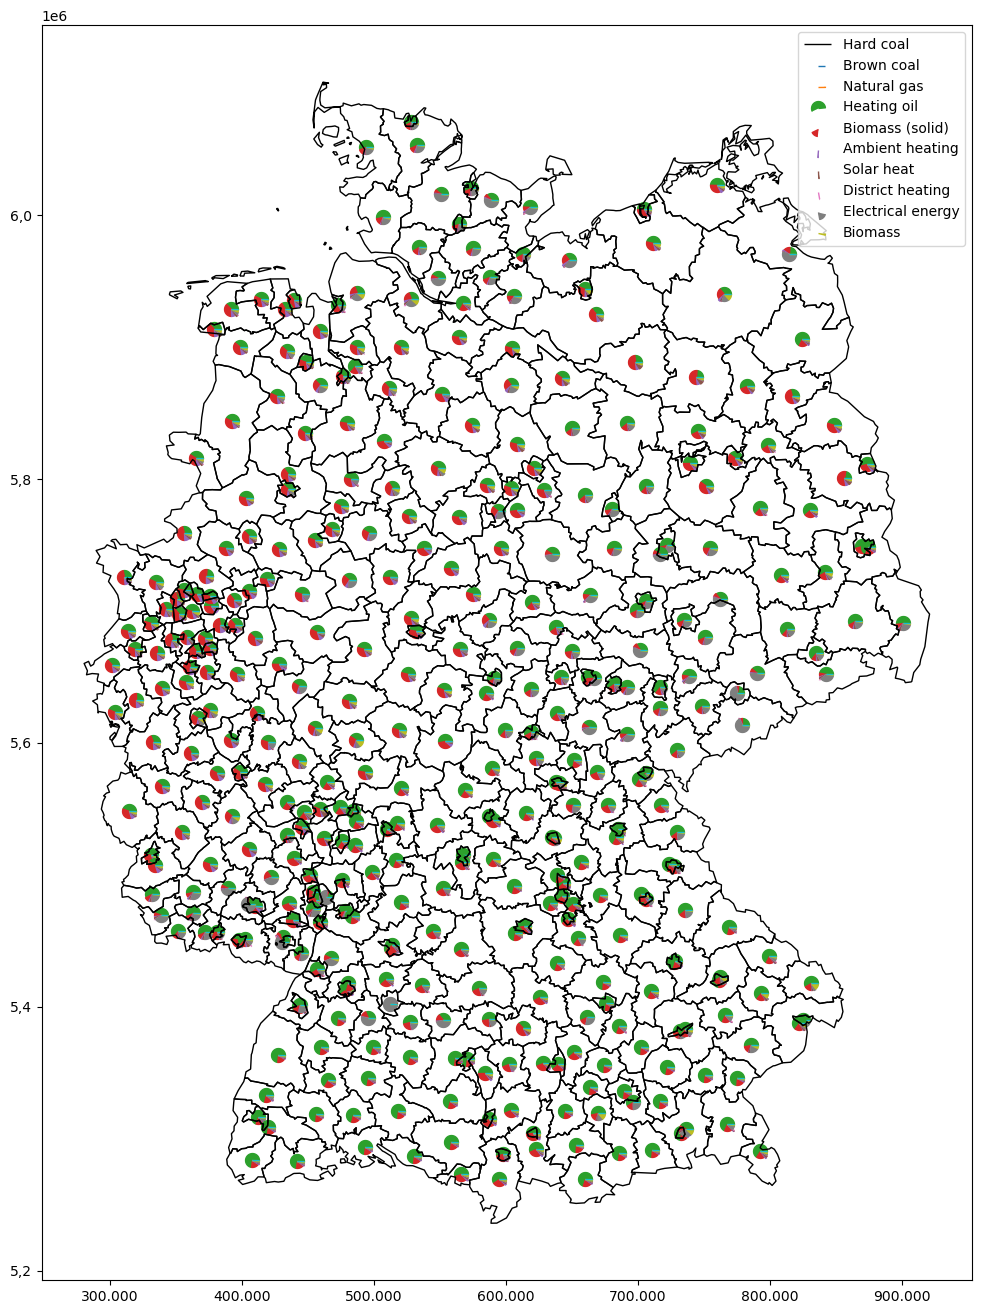

In [33]:
def draw_pie(dist, xpos, ypos, size, ax=None):
    """A function to plot pie charts"""
    """https://stackoverflow.com/questions/56337732/how-to-plot-scatter-pie-chart-using-matplotlib"""
    if ax is None:
        fig, ax = plt.subplots(figsize=(10,8))

    # for incremental pie slices
    cumsum = np.cumsum(dist)
    cumsum = cumsum/ cumsum[-1]
    pie = [0] + cumsum.tolist()

    for r1, r2 in zip(pie[:-1], pie[1:]):
        angles = np.linspace(2 * np.pi * r1, 2 * np.pi * r2)
        x = [0] + np.cos(angles).tolist()
        y = [0] + np.sin(angles).tolist()

        xy = np.column_stack([x, y])

        ax.scatter([xpos], [ypos], marker=xy, s=size)

    return ax

ax = nuts.boundary.plot(figsize=(12,40), color="black", linewidth=1) #Plot the polygon boundaries

for i, subframe in nuts.groupby("id_ags"): #For each id
    values = subframe.iloc[0] #Extract its values as a series
    slice_sizes = values[list(energy_carriers.values())].to_list() #Extract the values from the values column as a list, like [1, 3]
    x = values.x #The x coord for the pie
    y = values.y #y
    pie_size = 100
    draw_pie(dist=slice_sizes, xpos=x, ypos=y, size=pie_size, ax=ax)

plt.legend(list(energy_carriers.values()))

## Computing the hydrogen demand per district

For this first we will apply the criteria that will keep only the buildings that are not elegible for HP installation, meaning that we will keep the buildings that could use hydrogen.

Then, we will compute the hydrogen needs of the different industrial utilities. The hydrogen needs for each of the considered industries is as follows.

### Steel industry

We can consider that instead of using coal to make coke to purify the iron feed. We could use direct hydrogen reduction :

$$ Fe_2 O_3 + 3H_2 \rightarrow 2Fe + 3H_2O $$

From this, we can deduce that for each 2 moles of $Fe$, we need 3 moles of $H_2$. Iron's molar mass is 55.845 g/mol, and hydrogen's ($H_2$) 2.01568 g/mol. From this we find that for each kg of iron we need 54.171367 g of hydrogen.

However, given that steel is iron with a little percentage of carbon and other impurities, the total iron production will only be equal to around 97% wt of the steel production.

### Ammonia production

Similarly, we can take a look at the Haber-Bosch process balance equation to find how much hydrogen we need :

$$ N_2 + 3H_2 \rightarrow 2NH_3 $$

We already know the molar mass of hydrogen, the molar mass of ammonia is 17.031 g/mol. We conclude that for each kg of ammonia we need 176.14 g.

### Oil refineries

According to Hydrogen flow chart in China, in 2008, with a capacity of 227.69 million tons of crude, 1.02 million tons of hydrogen were consumed. 71 % of hydrogen was produced on-site largely through steam reforming.

$$ 1.02 \; \mathrm{million \; tons \; of \; hydrogen} \rightarrow 227.69 \; \mathrm{million \; tons \; of \; crude} $$

In [54]:
files = ["amonia.json", "refineries.json", "steel.json"]

importData = []

for file in files:
    with open("project_data/in/" + file, 'r', encoding = "utf-8") as f:
        importData.append(json.load(f))

toDelete = []
points = []

for dataE in importData:
    temp = []
    for element in dataE:
        if (element["Latitude"] == ""):
            toDelete.append(element)
            continue
        
        element["geometry"] = [float(element["Longitude"]), float(element["Latitude"])]

        del element["Latitude"]
        del element["Longitude"]
        
        temp.append(Point(element["geometry"][0], element["geometry"][1]))
    points.append(temp)

for toD in toDelete: # Delete the industry that doesn't have coordinates
    for dataE in importData:
        if (not toD in dataE): continue
        dataE.remove(toD)

In [55]:
amonia = copy.deepcopy(importData[0])
refineries = copy.deepcopy(importData[1])
steel = copy.deepcopy(importData[2])

aPoints = gpd.GeoDataFrame(geometry = copy.deepcopy(points[0]), crs = "EPSG:4326")
rPoints = gpd.GeoDataFrame(geometry = copy.deepcopy(points[1]), crs = "EPSG:4326")
sPoints = gpd.GeoDataFrame(geometry = copy.deepcopy(points[2]), crs = "EPSG:4326")

aPoints = aPoints.to_crs("EPSG:25832")
rPoints = rPoints.to_crs("EPSG:25832")
sPoints = sPoints.to_crs("EPSG:25832")

We use the previously stated conversions to find the H2 consumption in tons of H2

In [56]:
aPoints["consumption"] = [(int(a["Production"]) * 176.14 / 1000) for a in amonia]
rPoints["consumption"] = [(int(r["Production"]) * 1.02 / 227.69) for r in refineries]
sPoints["consumption"] = [(int(s["Production"]) * 0.97 * 54.171367 / 1000)for s in steel]

Search for the district where they are situated

In [57]:
aPoints = gpd.sjoin(aPoints, nuts)
rPoints = gpd.sjoin(rPoints, nuts)
sPoints = gpd.sjoin(sPoints, nuts)

Add the hydrogen consumption to the district total hydrogen consumption

In [68]:
nuts["consumption"] = np.zeros(401)

for index, row in aPoints.iterrows():
    nuts.loc[row["index_right"], "consumption"] += row["consumption"]
    
for index, row in rPoints.iterrows():
    nuts.loc[row["index_right"], "consumption"] += row["consumption"]

for index, row in sPoints.iterrows():
    nuts.loc[row["index_right"], "consumption"] += row["consumption"]

Show the consumption on a map

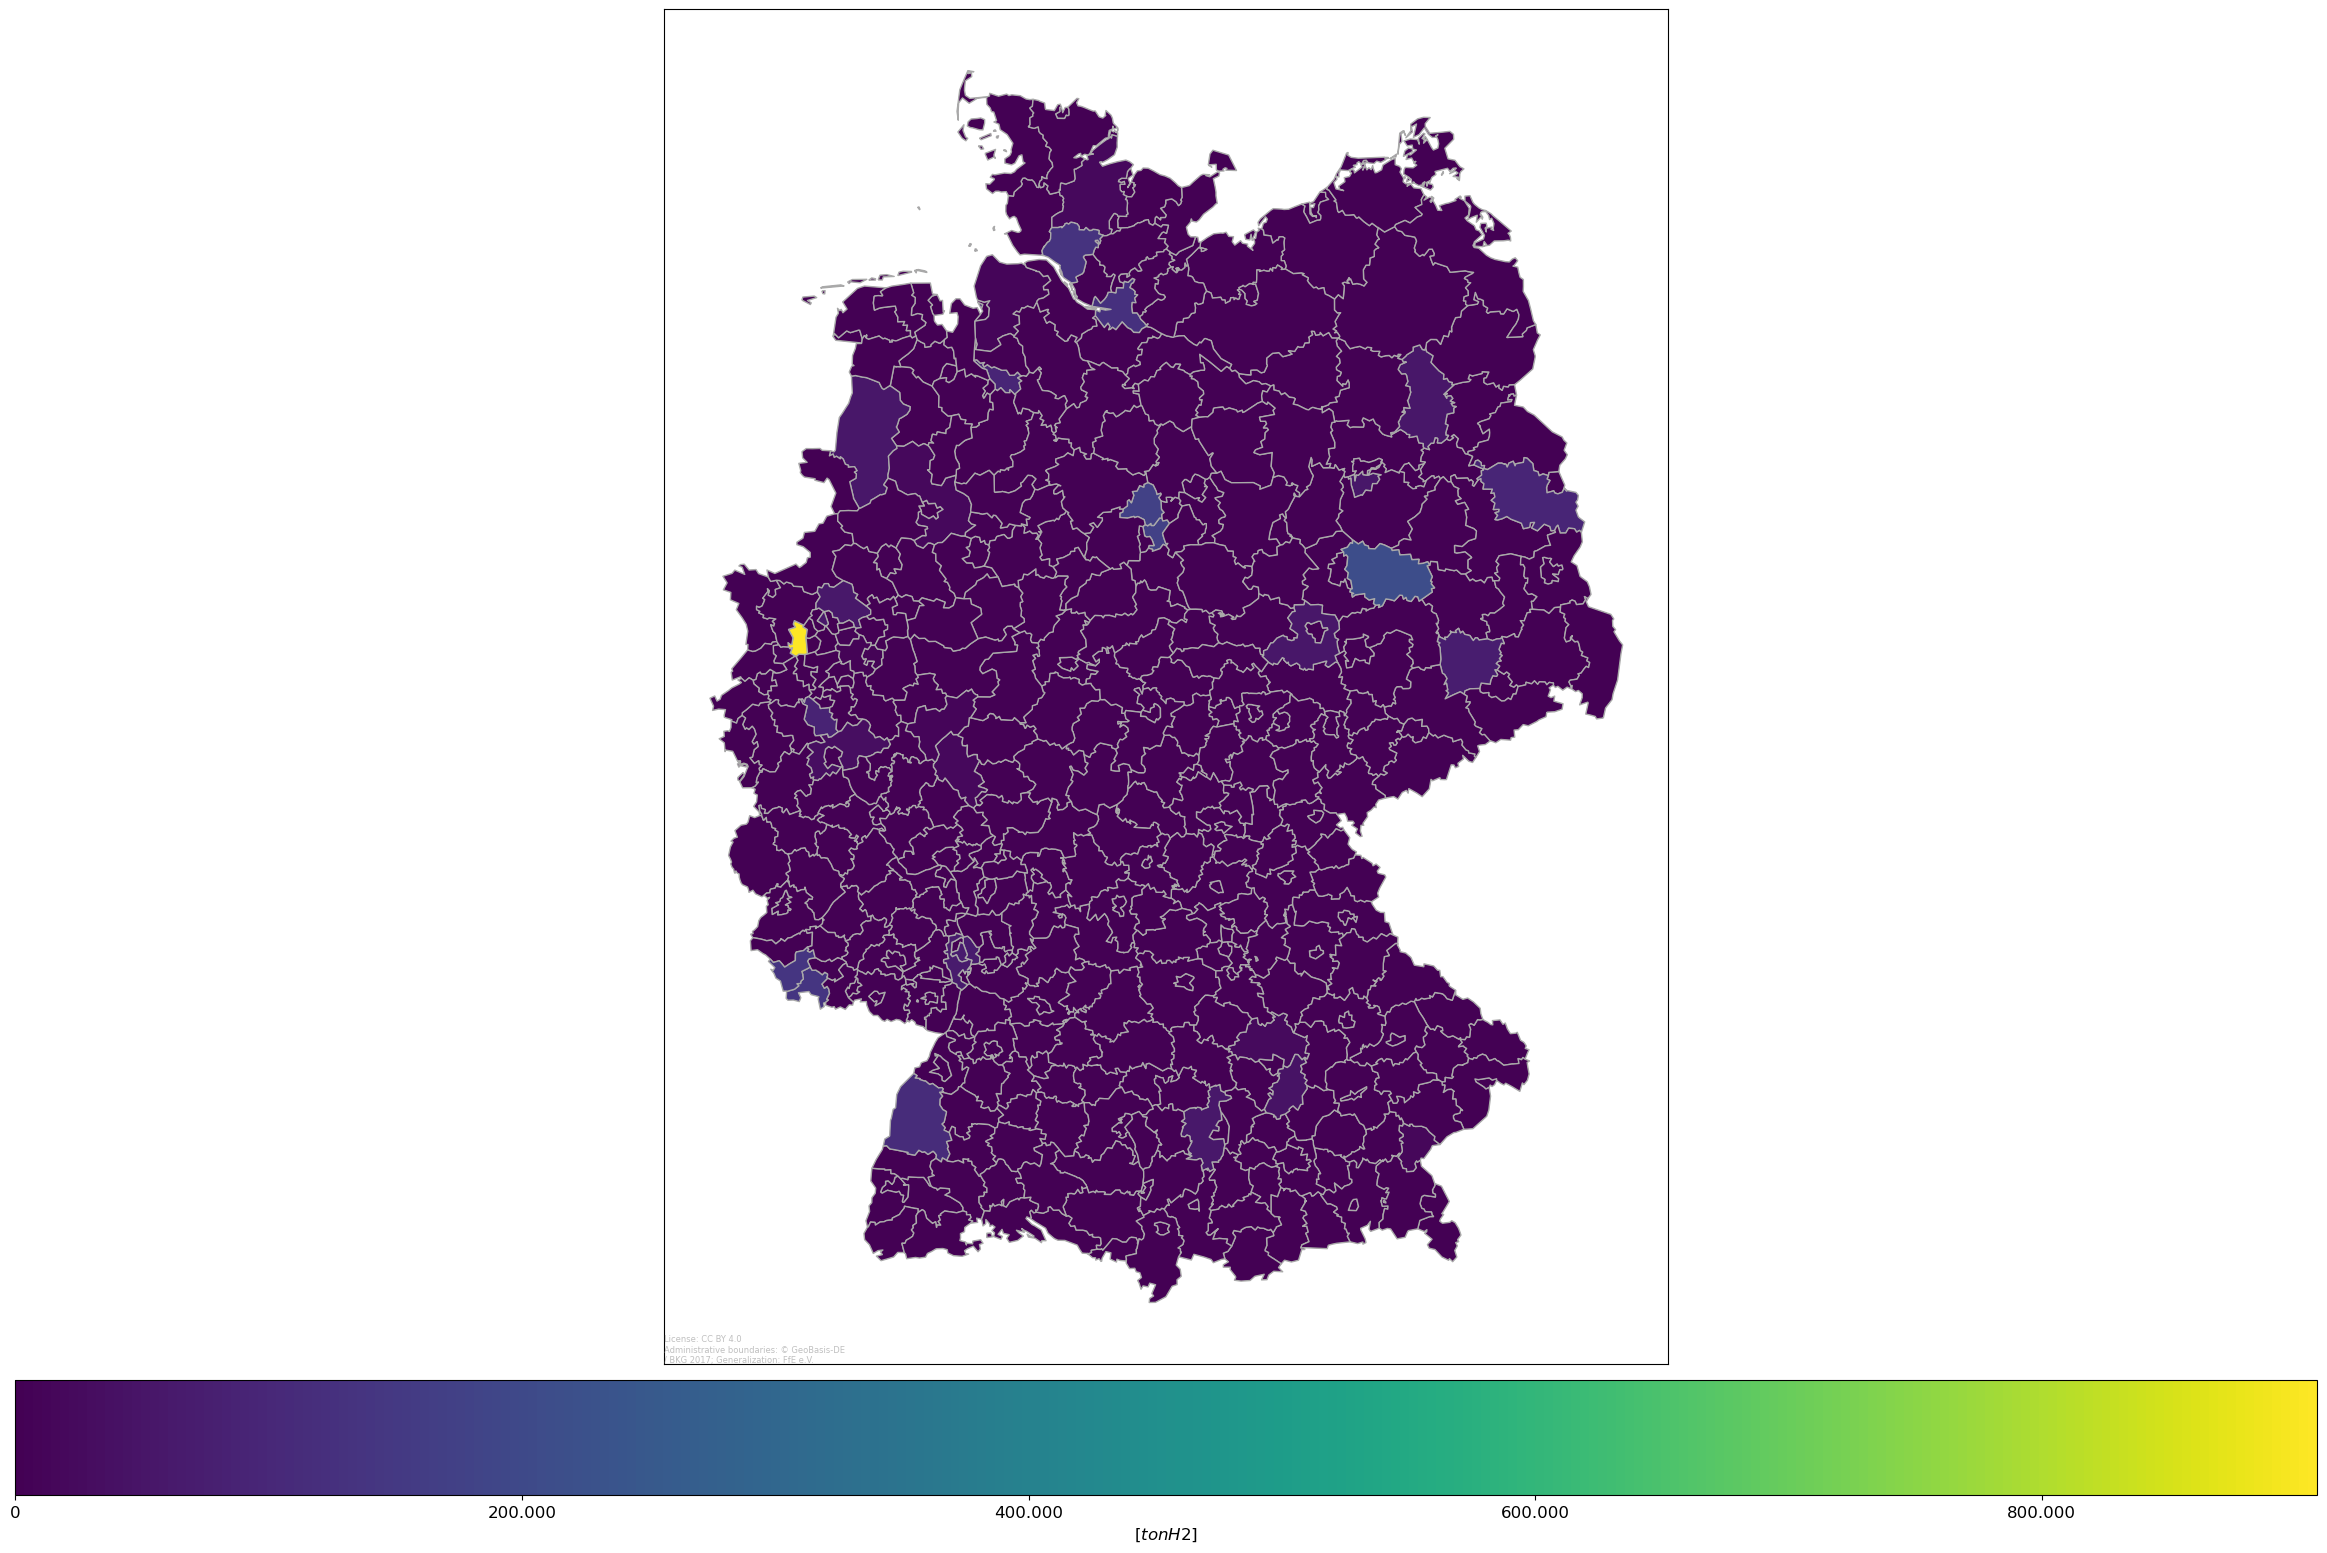

In [74]:
_, _ = plot.choropleth_map(nuts, columns = ["consumption"], unit = ["ton H2"], relative = False)

From http://www.ibpsa.org/proceedings/BSO2020/BSOV2020_Vatougiou.pdf COP curves for a 9kWe, 11.2kWe and 14kWe HP. x = outdoor dry-bulb temperature \[°C\] and y = condenser water temperature \[°C\]

 * 9kW for a house built after 2003
 * 11.2kW for a house built between 1976 and 2002
 * 14kW for a house built before 1975

In [24]:
x = np.linspace(-10, 30) # °C
y = 35 # °C

COP1 = 6.9 + 0.2*x + (9.9e-4 * (x**2)) - (0.12 * y) + (6e-4 * (y**2)) - (2.8e-3 * x * y)
COP2 = 5.2+(0.2*x) + (1.6e-3*(x**2)) - (2.5e-2*y) - (5.8e-4*(y**2)) - (2.2e-3*x*y)
COP3 = 4.7+(0.17*x)-(5.7e-5*(x**2))-(2.8e-2*y)-(2.6e-4*(y**2))-(2e-3*x*y)

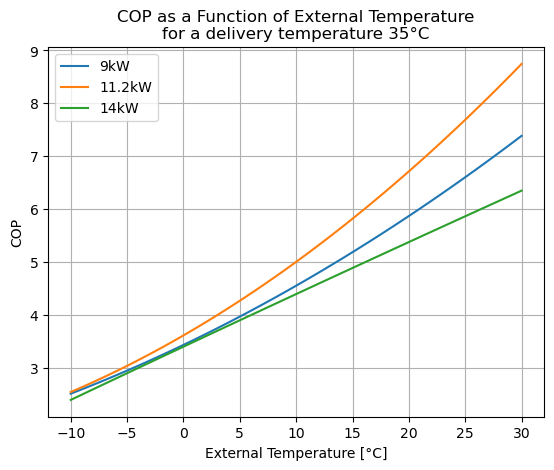

In [26]:
plt.plot(x, COP1, label='9kW')
plt.plot(x, COP2, label='11.2kW')
plt.plot(x, COP3, label='14kW')

# Adding labels and title
plt.xlabel('External Temperature [°C]')
plt.ylabel('COP [-]')
plt.title('COP as a Function of External Temperature\nfor a delivery temperature 35°C')

# Adding legend
plt.legend()
plt.grid()

# Show the plot
plt.show()

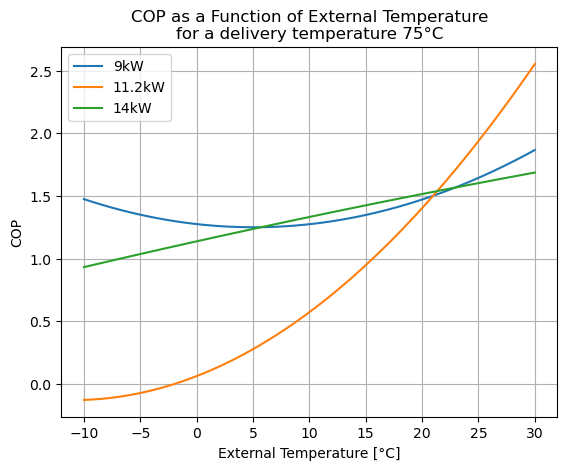

In [27]:
y = 75 # °C

COP1 = 6.9 + 0.2*x + (9.9e-4 * (x**2)) - (0.12 * y) + (6e-4 * (y**2)) - (2.8e-3 * x * y)
COP2 = 5.2+(0.2*x) + (1.6e-3*(x**2)) - (2.5e-2*y) - (5.8e-4*(y**2)) - (2.2e-3*x*y)
COP3 = 4.7+(0.17*x)-(5.7e-5*(x**2))-(2.8e-2*y)-(2.6e-4*(y**2))-(2e-3*x*y)

plt.plot(x, COP1, label='9kW')
plt.plot(x, COP2, label='11.2kW')
plt.plot(x, COP3, label='14kW')

# Adding labels and title
plt.xlabel('External Temperature [°C]')
plt.ylabel('COP [-]')
plt.title('COP as a Function of External Temperature\nfor a delivery temperature 75°C')

# Adding legend
plt.legend()
plt.grid()

# Show the plot
plt.show()